In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time, datetime

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')
from ce_utils import load_path, train_valid_split, damped_exp_LR, load_random_minibatch, shuffle
from ce_utils import training_history

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [2]:
neg_path = load_path('train', 'n', 'neg', data = 'sm')
# redspot_path = load_path('train', 'h', 'redspot', data = 'sm')
# angio_path = load_path('train', 'h', 'angio', data = 'sm')
# active_path = load_path('train', 'h', 'active', data = 'sm')
ero_path = load_path('train', 'd', 'ero', data = 'sm')
ulcer_path = load_path('train', 'd', 'ulcer', data = 'sm')
str_path = load_path('train', 'd', 'str', data = 'sm')

print("negative:",neg_path.shape)
# print("red spot:",redspot_path.shape)
# print("angioectasia:",angio_path.shape)
# print("active_bleeding:",active_path.shape)
print("erosion:",ero_path.shape)
print("ulcer:",ulcer_path.shape)
print("stricture:",str_path.shape)

negative: (49999,)
erosion: (5900,)
ulcer: (5856,)
stricture: (825,)


In [3]:
neg_train_path, neg_valid_path = train_valid_split(neg_path)
# redspot_train_path, redspot_valid_path = train_valid_split(redspot_path)
# angio_train_path, angio_valid_path = train_valid_split(angio_path)
# active_train_path, active_valid_path = train_valid_split(active_path)
ero_train_path, ero_valid_path = train_valid_split(ero_path)
ulcer_train_path, ulcer_valid_path = train_valid_split(ulcer_path)
str_train_path, str_valid_path = train_valid_split(str_path)

print("negative:", neg_train_path.shape, neg_valid_path.shape)
# print("red spot:", redspot_train_path.shape, redspot_valid_path.shape)
# print("angioectasia:", angio_train_path.shape, angio_valid_path.shape)
# print("active bleeding:", active_train_path.shape, active_valid_path.shape)
print("erosion:", ero_train_path.shape, ero_valid_path.shape)
print("ulcer:", ulcer_train_path.shape, ulcer_valid_path.shape)
print("stricture:", str_train_path.shape, str_valid_path.shape)

negative: (42499,) (7500,)
erosion: (5015,) (885,)
ulcer: (4978,) (878,)
stricture: (701,) (124,)


# Model

In [4]:
input_h = 512
input_w = 512
input_ch = 3

k1_ch = 16
# 256 256 16

k2_ch = 16
# 128 128 16

k3_ch = 16
# 64 64 16

k4_ch = 32
# 32 32 32

k5_ch = 32
# 16 16 32

k6_ch = 32
# 8 8 32

k7_ch = 64
# 4 4 64

n_hidden1 = 100
n_hidden2 = 50
n_output = 2

In [5]:
class CE_cnn:
    def __init__(self, k1_ch, k2_ch, k3_ch, k4_ch, k5_ch, k6_ch, k7_ch, n_hidden1, n_hidden2, n_output):
        self.k1_ch = k1_ch
        self.k2_ch = k2_ch
        self.k3_ch = k3_ch
        self.k4_ch = k4_ch
        self.k5_ch = k5_ch
        self.k6_ch = k6_ch
        self.k7_ch = k7_ch
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_output = n_output
    def conv_block(self, x, k_channel, maxp_name = 'maxp'):
        conv1 = tf.layers.conv2d(inputs = x, 
                                 filters = k_channel, 
                                 kernel_size = [3, 3], 
                                 padding = "SAME",
                                 activation= tf.nn.relu)
        conv2 = tf.layers.conv2d(inputs = conv1, 
                                 filters = k_channel, 
                                 kernel_size = [3, 3], 
                                 padding = "SAME",
                                 activation= tf.nn.relu)
        maxp = tf.layers.max_pooling2d(inputs = conv2, 
                                       pool_size = [2, 2], 
                                       strides = 2,
                                       name = maxp_name)
        return maxp

    def fc2_layers(self, x, n_hidden1, n_hidden2, n_output, score_name = 'score'):
        maxp_re = tf.layers.flatten(x)
        hidden1 = tf.layers.dense(inputs = maxp_re, 
                                  units = n_hidden1,
                                  activation = tf.nn.relu)
        hidden1 = tf.layers.dropout(hidden1, rate = 0.3, training = is_training) # Drouout
        hidden2 = tf.layers.dense(inputs = hidden1, 
                                  units = n_hidden2,
                                  activation = tf.nn.relu)
        hidden2 = tf.layers.dropout(hidden2, rate = 0.3, training = is_training) # Drouout
        score = tf.layers.dense(inputs = hidden2, units = n_output, name = score_name)
        return score

    def inf(self, x):
        conv1 = self.conv_block(x, self.k1_ch, 'maxp1')
        conv2 = self.conv_block(conv1, self.k2_ch, 'maxp2')
        conv3 = self.conv_block(conv2, self.k3_ch, 'maxp3')
        conv4 = self.conv_block(conv3, self.k4_ch, 'maxp4')
        conv5 = self.conv_block(conv4, self.k5_ch, 'maxp5')
        conv6 = self.conv_block(conv5, self.k6_ch, 'maxp6')
        conv7 = self.conv_block(conv6, self.k7_ch, 'maxp7')

        score = self.fc2_layers(conv7, self.n_hidden1, self.n_hidden2, self.n_output, 'score')

        return score

In [6]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
#rate = tf.placeholder(tf.float32, name = 'rate') # tf.layers.dropout용 얼만큼 드랍아웃할건지
LR = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool, name = 'is_training')

model = CE_cnn(k1_ch, k2_ch, k3_ch, k4_ch, k5_ch, k6_ch, k7_ch, n_hidden1, n_hidden2, n_output)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

# update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(update_ops):
#     optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
optm = tf.train.AdamOptimizer(LR).minimize(loss)

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

W0111 17:20:19.905592 140488555140864 deprecation.py:323] From <ipython-input-5-249d499180cf>:18: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0111 17:20:19.910858 140488555140864 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0111 17:20:20.127003 140488555140864 deprecation.py:323] From <ipython-input-5-249d499180cf>:27: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0111 17:20:20.409981 140488555140864 deprecation.py:323] F

# Training

## N:D=3:7 batch-size and damaped exp LR

damped_exp_LR(15000) <br>
total_batch = 100 <br>
cal_interval = 10 <br>
prt_interval = 100 <br>
early stopping = True <br>

In [7]:
d_train_path = np.hstack([ero_train_path, ulcer_train_path, str_train_path])
d_valid_path = np.hstack([ero_valid_path, ulcer_valid_path, str_valid_path])

d_train_path = shuffle(d_train_path, None)
d_valid_path = shuffle(d_valid_path, None)

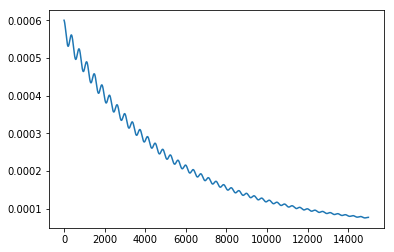

In [8]:
D_lr = damped_exp_LR(15000)

plt.plot(D_lr)

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 70.00 %    || 50.00 %    || 0.60971361 || 0.80917966
--------------------------------------------------------------


W0111 17:24:43.561910 140488555140864 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*200] || 70.00 %    || 50.00 %    || 0.50392449 || 0.81315565
--------------------------------------------------------------
[*300] || 84.00 %    || 79.00 %    || 0.36815849 || 0.46300888
--------------------------------------------------------------
[*400] || 94.00 %    || 81.00 %    || 0.17227794 || 0.35941979
--------------------------------------------------------------
[*500] || 91.00 %    || 90.00 %    || 0.27744043 || 0.26409185
--------------------------------------------------------------
[*600] || 85.00 %    || 79.00 %    || 0.38822395 || 0.39471424
--------------------------------------------------------------
[*700] || 91.00 %    || 77.00 %    || 0.27677551 || 0.44575420
--------------------------------------------------------------
[*800] || 89.00 %    || 84.00 %    || 0.30443254 || 0.32365760
--------------------------------------------------------------
[*900] || 89.00 %    || 87.00 %    || 0.30280241 || 0.29030201
-------------------------------------------------------

[6700] || 98.00 %    || 99.00 %    || 0.06629916 || 0.03483005
--------------------------------------------------------------
[6800] || 98.00 %    || 97.00 %    || 0.04929480 || 0.04707634
--------------------------------------------------------------
[6900] || 98.00 %    || 95.00 %    || 0.04046260 || 0.09093831
--------------------------------------------------------------
[7000] || 99.00 %    || 94.00 %    || 0.04591639 || 0.18930885
--------------------------------------------------------------
[7100] || 97.00 %    || 98.00 %    || 0.04647717 || 0.05677494
--------------------------------------------------------------
[7200] || 100.00 %    || 97.00 %    || 0.00780891 || 0.06914012
--------------------------------------------------------------
[7300] || 100.00 %    || 94.00 %    || 0.00834202 || 0.13547762
--------------------------------------------------------------
[7400] || 98.00 %    || 97.00 %    || 0.03361126 || 0.05897980
-----------------------------------------------------

[13200] || 100.00 %    || 99.00 %    || 0.00356353 || 0.01159578
--------------------------------------------------------------
[13300] || 100.00 %    || 99.00 %    || 0.00126013 || 0.03637008
--------------------------------------------------------------
[13400] || 100.00 %    || 98.00 %    || 0.00342215 || 0.12132111
--------------------------------------------------------------
[13500] || 100.00 %    || 96.00 %    || 0.00308329 || 0.10265879
--------------------------------------------------------------
[13600] || 100.00 %    || 92.00 %    || 0.00215728 || 0.38842034
--------------------------------------------------------------
[13700] || 100.00 %    || 94.00 %    || 0.00622493 || 0.15928428
--------------------------------------------------------------
[13800] || 100.00 %    || 96.00 %    || 0.00506225 || 0.07431024
--------------------------------------------------------------
[13900] || 99.00 %    || 97.00 %    || 0.00769649 || 0.17754814
----------------------------------------

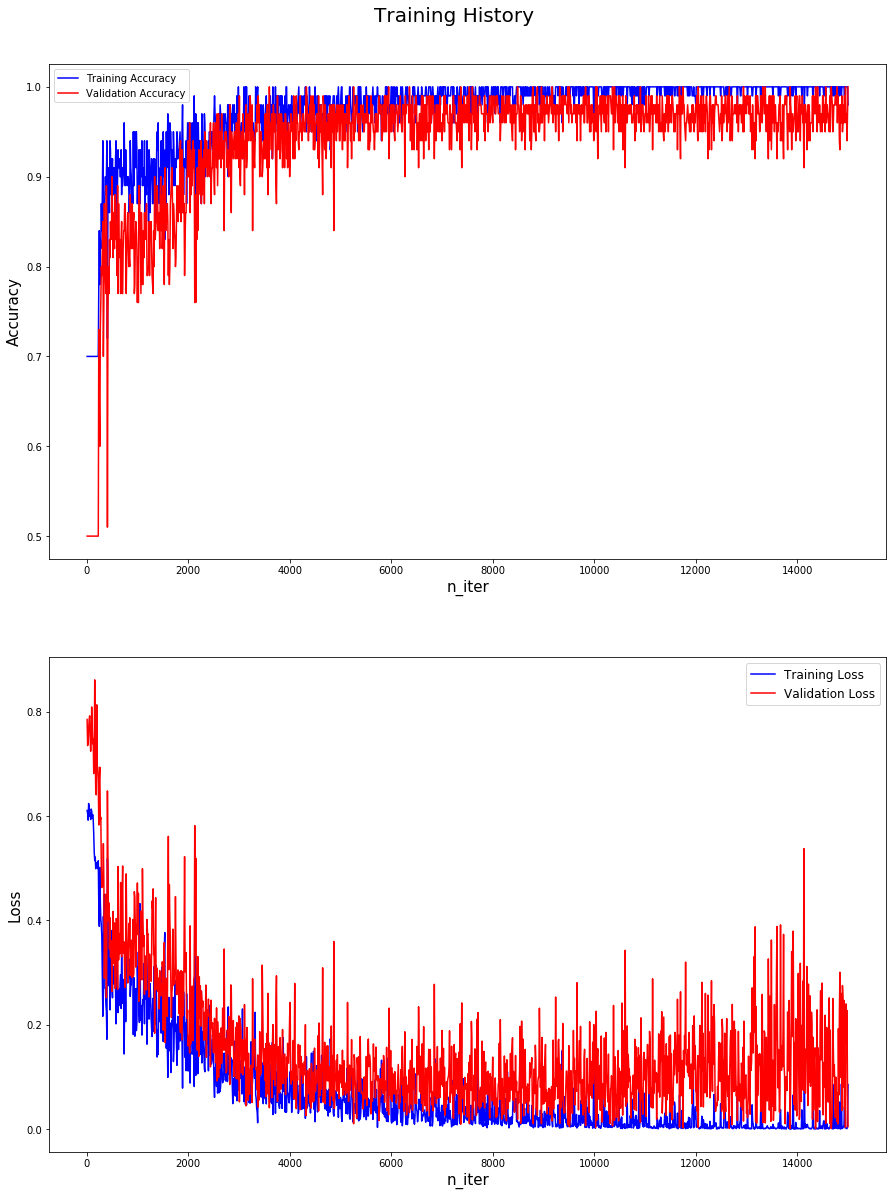

In [9]:
n_iter = 0
total_batch = 100
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    
    neg_batch = int(0.3*total_batch)
    d_batch = int(0.7*total_batch)
    
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = neg_batch)
    d_train_x, d_train_y = load_random_minibatch(d_train_path, cls = 1, batch_size = d_batch)
    train_x = np.vstack([neg_train_x, d_train_x])
    train_y = np.vstack([neg_train_y, d_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = int(total_batch/2))
        d_valid_x, d_valid_y = load_random_minibatch(d_valid_path, cls = 1, batch_size = int(total_batch/2))
        valid_x = np.vstack([neg_valid_x, d_valid_x])
        valid_y = np.vstack([neg_valid_y, d_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'N3D7_1_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 15000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

## equal batch-size by class and damaped exp LR and early stopping

damped_exp_LR(15000) <br>
t_batch = 50 <br>
v_batch = 50 <br>
cal_interval = 10 <br>
prt_interval = 100 <br>
early stopping = True <br>

In [15]:
d_train_path = np.hstack([ero_train_path, ulcer_train_path, str_train_path])
d_valid_path = np.hstack([ero_valid_path, ulcer_valid_path, str_valid_path])

d_train_path = shuffle(d_train_path, None)
d_valid_path = shuffle(d_valid_path, None)

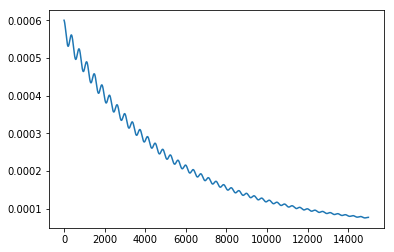

In [16]:
D_lr = damped_exp_LR(15000)

plt.plot(D_lr)

In [ ]:
n_iter = 0
t_batch = 50
v_batch = 50
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    d_train_x, d_train_y = load_random_minibatch(d_train_path, cls = 1, batch_size = t_batch)
    train_x = np.vstack([neg_train_x, d_train_x])
    train_y = np.vstack([neg_train_y, d_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        d_valid_x, d_valid_y = load_random_minibatch(d_valid_path, cls = 1, batch_size = v_batch)
        valid_x = np.vstack([neg_valid_x, d_valid_x])
        valid_y = np.vstack([neg_valid_y, d_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'ND_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
#         if n_iter == 30000:
#             break
        if n_iter > 5000:
            if np.max(accr_train) < 0.9:
                if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
                    hist.early_under(n_iter)
                    early_stopping = True
                    break
            if np.mean(accr_train[-50:]) >= 0.995:
                if (
                    np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
                    loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
                    ):
                    hist.early_over(n_iter)
                    early_stopping = True
                    break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss


W0110 00:25:45.290334 140187849426688 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*100] || 69.00 %    || 68.00 %    || 0.58030725 || 0.59405231
--------------------------------------------------------------


## equal batch-size by class and damaped exp LR

damped_exp_LR(30000, alpha = 0.0001) <br>
t_batch = 30 <br>
v_batch = 120 <br>
cal_interval = 100 <br>
prt_interval = 100 <br>
early stopping = False <br>

In [7]:
d_train_path = np.hstack([ero_train_path, ulcer_train_path, str_train_path])
d_valid_path = np.hstack([ero_valid_path, ulcer_valid_path, str_valid_path])

d_train_path = shuffle(d_train_path, None)
d_valid_path = shuffle(d_valid_path, None)

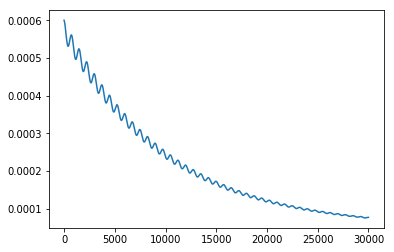

In [8]:
plt.plot(damped_exp_LR(30000, alpha = 0.0001))
D_lr = damped_exp_LR(30000, alpha = 0.0001)

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 60.00 %    || 64.58 %    || 0.67377019 || 0.66385269
--------------------------------------------------------------
[*200] || 78.33 %    || 82.08 %    || 0.42938888 || 0.40113601
--------------------------------------------------------------
[*300] || 80.00 %    || 87.50 %    || 0.34429103 || 0.27350420
--------------------------------------------------------------
[*400] || 91.67 %    || 88.33 %    || 0.28542012 || 0.29031405
--------------------------------------------------------------
[*500] || 91.67 %    || 91.25 %    || 0.28141412 || 0.23153095
--------------------------------------------------------------
[*600] || 96.67 %    || 85.00 %    || 0.13321659 || 0.36387327
--------------------------------------------------------------
[*700] || 85.00 %    || 86.67 %    || 0.32233351 || 0.39326918
--------------------------------------------------------------
[*800] || 93.33 %    || 88.75 %    || 0.20329198 || 0.2

W0108 15:58:02.202932 140228156172032 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[1100] || 86.67 %    || 94.17 %    || 0.23938452 || 0.15245299
--------------------------------------------------------------
[1200] || 93.33 %    || 95.00 %    || 0.14409965 || 0.15060325
--------------------------------------------------------------
[1300] || 95.00 %    || 92.50 %    || 0.17829596 || 0.18669824
--------------------------------------------------------------
[1400] || 96.67 %    || 90.42 %    || 0.08108237 || 0.25508925
--------------------------------------------------------------
[1500] || 90.00 %    || 94.17 %    || 0.28247327 || 0.14751521
--------------------------------------------------------------
[1600] || 96.67 %    || 93.75 %    || 0.07736246 || 0.16999559
--------------------------------------------------------------
[1700] || 93.33 %    || 93.33 %    || 0.16133589 || 0.17600033
--------------------------------------------------------------
[1800] || 98.33 %    || 92.08 %    || 0.06749398 || 0.18844357
-------------------------------------------------------

[7600] || 95.00 %    || 95.42 %    || 0.07739957 || 0.12865314
--------------------------------------------------------------
[7700] || 98.33 %    || 92.92 %    || 0.08180711 || 0.24100260
--------------------------------------------------------------
[7800] || 100.00 %    || 96.25 %    || 0.00938881 || 0.13993745
--------------------------------------------------------------
[7900] || 96.67 %    || 94.17 %    || 0.08335436 || 0.15722114
--------------------------------------------------------------
[8000] || 98.33 %    || 95.42 %    || 0.03158782 || 0.21627374
--------------------------------------------------------------
[8100] || 100.00 %    || 93.75 %    || 0.02855349 || 0.21676172
--------------------------------------------------------------
[8200] || 100.00 %    || 95.83 %    || 0.01985613 || 0.19048315
--------------------------------------------------------------
[8300] || 100.00 %    || 91.67 %    || 0.02405260 || 0.41997412
---------------------------------------------------

[14100] || 100.00 %    || 96.67 %    || 0.00242124 || 0.21210918
--------------------------------------------------------------
[14200] || 100.00 %    || 93.75 %    || 0.00301087 || 0.29799873
--------------------------------------------------------------
[14300] || 100.00 %    || 95.83 %    || 0.00875428 || 0.17574835
--------------------------------------------------------------
[14400] || 98.33 %    || 96.25 %    || 0.01698478 || 0.14747547
--------------------------------------------------------------
[14500] || 98.33 %    || 95.83 %    || 0.15446423 || 0.33135590
--------------------------------------------------------------
[14600] || 98.33 %    || 92.92 %    || 0.03423112 || 0.37566149
--------------------------------------------------------------
[14700] || 100.00 %    || 95.00 %    || 0.00101003 || 0.21096346
--------------------------------------------------------------
[14800] || 100.00 %    || 92.92 %    || 0.00102635 || 0.47448000
------------------------------------------

[20600] || 100.00 %    || 92.50 %    || 0.00029472 || 0.55051512
--------------------------------------------------------------
[20700] || 100.00 %    || 94.17 %    || 0.00028625 || 0.39218649
--------------------------------------------------------------
[20800] || 100.00 %    || 93.75 %    || 0.00024768 || 0.39684457
--------------------------------------------------------------
[20900] || 100.00 %    || 94.17 %    || 0.00027203 || 0.38890335
--------------------------------------------------------------
[21000] || 100.00 %    || 96.25 %    || 0.00049478 || 0.22798859
--------------------------------------------------------------
[21100] || 100.00 %    || 94.58 %    || 0.00053635 || 0.39467317
--------------------------------------------------------------
[21200] || 100.00 %    || 93.75 %    || 0.00089013 || 0.35474730
--------------------------------------------------------------
[21300] || 100.00 %    || 94.58 %    || 0.00074265 || 0.27046302
---------------------------------------

[27100] || 100.00 %    || 94.17 %    || 0.00001294 || 0.38648906
--------------------------------------------------------------
[27200] || 100.00 %    || 96.67 %    || 0.00000651 || 0.31546849
--------------------------------------------------------------
[27300] || 100.00 %    || 94.58 %    || 0.00014945 || 0.36042580
--------------------------------------------------------------
[27400] || 100.00 %    || 95.83 %    || 0.00002298 || 0.59123909
--------------------------------------------------------------
[27500] || 100.00 %    || 96.67 %    || 0.00004914 || 0.26040572
--------------------------------------------------------------
[27600] || 100.00 %    || 93.33 %    || 0.00003791 || 0.67022854
--------------------------------------------------------------
[27700] || 100.00 %    || 92.92 %    || 0.00013650 || 0.44488794
--------------------------------------------------------------
[27800] || 100.00 %    || 95.83 %    || 0.00099573 || 0.43816903
---------------------------------------

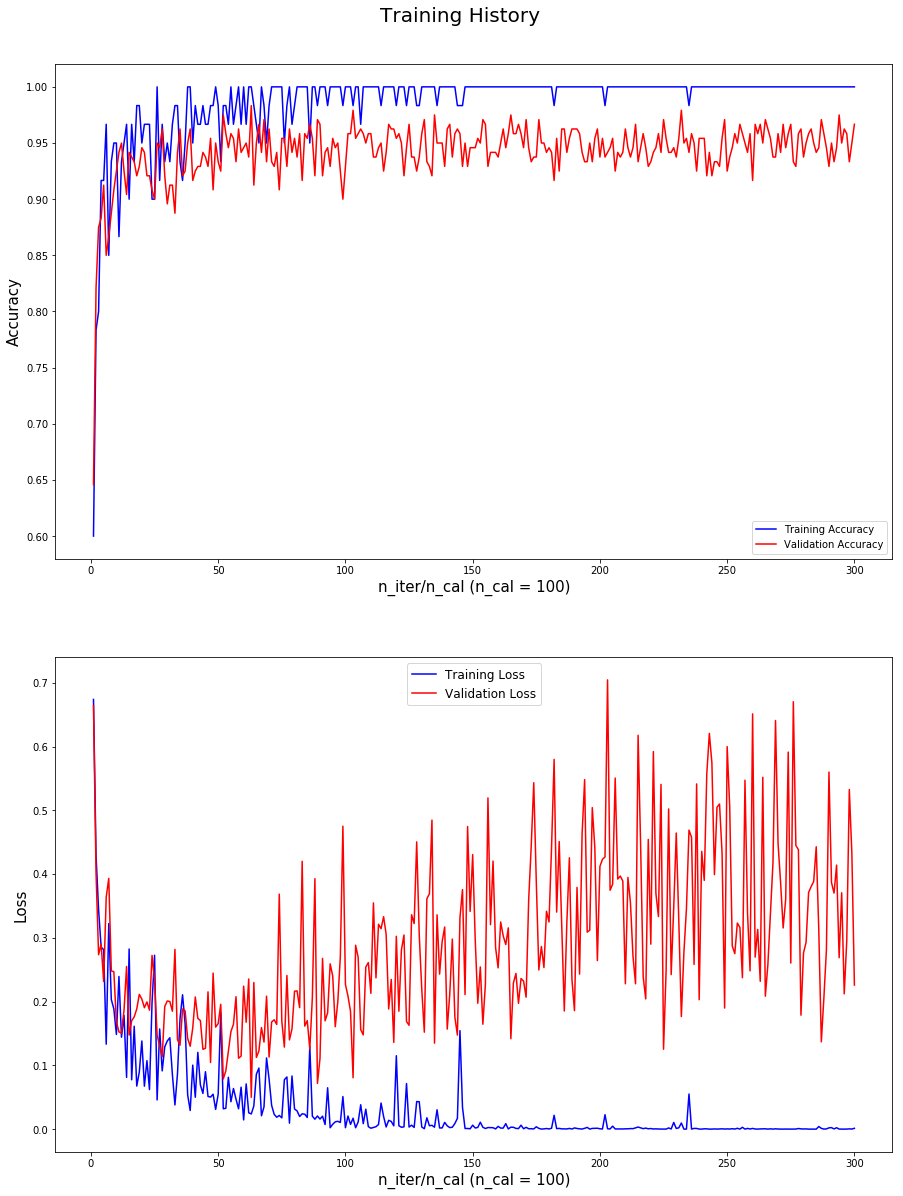

In [9]:
n_iter = 0
t_batch = 30
v_batch = 120
cal_interval = 100
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    d_train_x, d_train_y = load_random_minibatch(d_train_path, cls = 1, batch_size = t_batch)
    train_x = np.vstack([neg_train_x, d_train_x])
    train_y = np.vstack([neg_train_y, d_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        d_valid_x, d_valid_y = load_random_minibatch(d_valid_path, cls = 1, batch_size = v_batch)
        valid_x = np.vstack([neg_valid_x, d_valid_x])
        valid_y = np.vstack([neg_valid_y, d_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'ND_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 30000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

## equal batch-size by class and eqaul batch-size by lesion

lr = 1e-4 --> lr *= 0.99999 <br>
t_batch = 30 <br>
v_batch = 120 <br>
    - lesion_batch = t_batch(v_batch)/3
cal_interval = 100 <br>
prt_interval = 1000 <br>
early stopping = False <br>

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[1000] || 93.33 %    || 90.00 %    || 0.19303365 || 0.25201687
--------------------------------------------------------------
[2000] || 90.00 %    || 92.92 %    || 0.28702152 || 0.14817838
--------------------------------------------------------------
[3000] || 91.67 %    || 92.08 %    || 0.21767955 || 0.19368930
--------------------------------------------------------------
[4000] || 90.00 %    || 92.08 %    || 0.17060703 || 0.23837566
--------------------------------------------------------------
[5000] || 95.00 %    || 90.83 %    || 0.17687868 || 0.28720754
--------------------------------------------------------------
[6000] || 95.00 %    || 96.67 %    || 0.13710324 || 0.10632398
--------------------------------------------------------------
[7000] || 96.67 %    || 95.42 %    || 0.14320603 || 0.11571004
--------------------------------------------------------------
[8000] || 100.00 %    || 92.08 %    || 0.05653979 || 0.

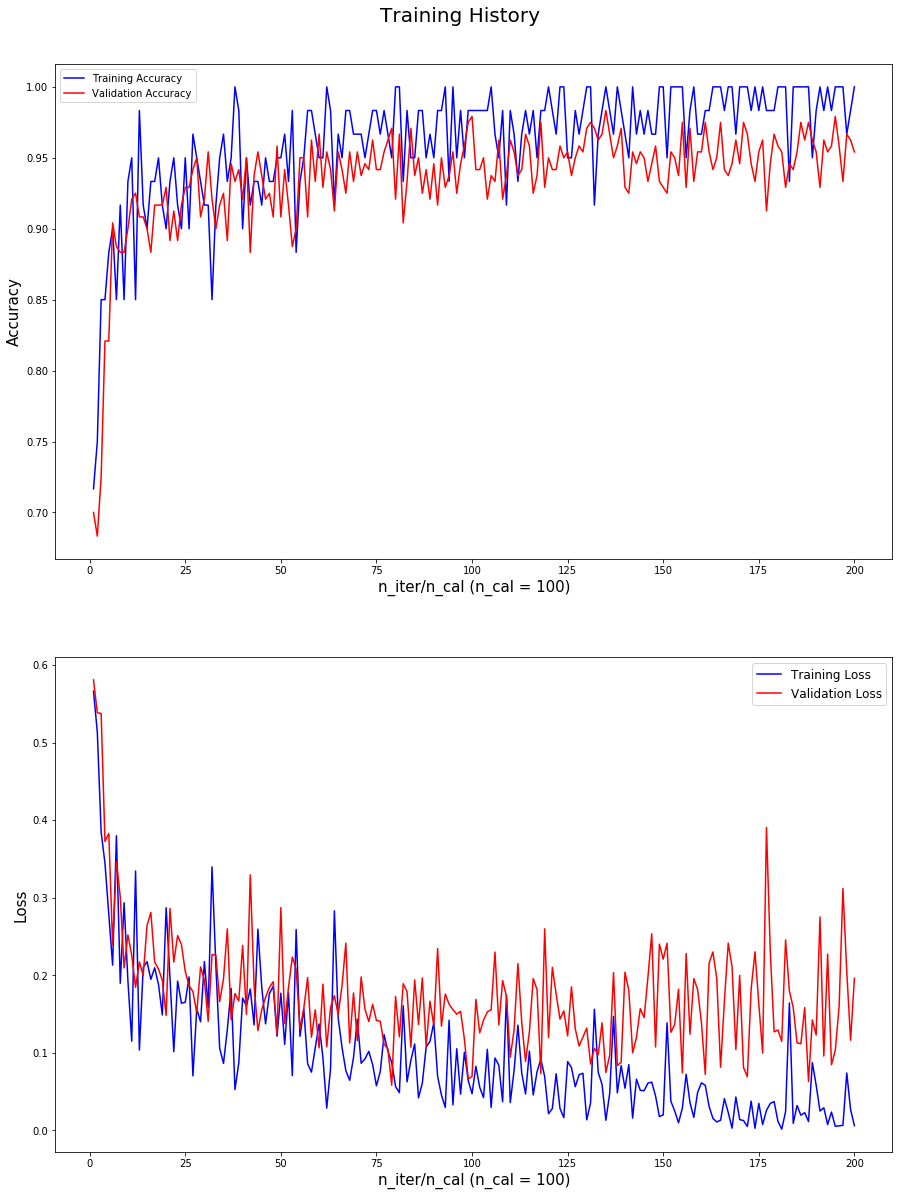

In [13]:
## test결과 - 각 병변별로 batch 수를 동일하게 불러오다보니 n수가 많은 병변을 더 잘 못 보는 느낌 ?

lr = 1e-4
n_iter = 0
t_batch = 30
v_batch = 120
cal_interval = 100
prt_interval = 1000
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    ero_train_x, ero_train_y  = load_random_minibatch(ero_train_path, cls = 1, batch_size = int(t_batch/3))
    ulcer_train_x, ulcer_train_y = load_random_minibatch(ulcer_train_path, cls = 1, batch_size = int(t_batch/3))
    str_train_x, str_train_y = load_random_minibatch(str_train_path, cls = 1, batch_size = int(t_batch/3))
    train_x = np.vstack([neg_train_x, ero_train_x, ulcer_train_x, str_train_x])
    train_y = np.vstack([neg_train_y, ero_train_y, ulcer_train_y, str_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: lr})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        ero_valid_x, ero_valid_y  = load_random_minibatch(ero_valid_path, cls = 1, batch_size = int(v_batch/3))
        ulcer_valid_x, ulcer_valid_y = load_random_minibatch(ulcer_valid_path, cls = 1, batch_size = int(v_batch/3))
        str_valid_x, str_valid_y = load_random_minibatch(str_valid_path, cls = 1, batch_size = int(v_batch/3))
        valid_x = np.vstack([neg_valid_x, ero_valid_x, ulcer_valid_x, str_valid_x])
        valid_y = np.vstack([neg_valid_y, ero_valid_y, ulcer_valid_y, str_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'ND_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 20000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    lr *= 0.99999
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[21000] || 98.33 %    || 97.50 %    || 0.01799883 || 0.12576990
--------------------------------------------------------------
[22000] || 98.33 %    || 97.08 %    || 0.07829151 || 0.16554965
--------------------------------------------------------------
[23000] || 100.00 %    || 94.17 %    || 0.01528577 || 0.19027846
--------------------------------------------------------------
[24000] || 98.33 %    || 94.17 %    || 0.02073841 || 0.25927207
--------------------------------------------------------------
[25000] || 100.00 %    || 93.75 %    || 0.00689149 || 0.29452080
--------------------------------------------------------------
[26000] || 98.33 %    || 96.25 %    || 0.04031411 || 0.18322830
--------------------------------------------------------------
[27000] || 100.00 %    || 95.00 %    || 0.00225666 || 0.36055720
--------------------------------------------------------------
[28000] || 100.00 %    || 92.92 %    || 0.003

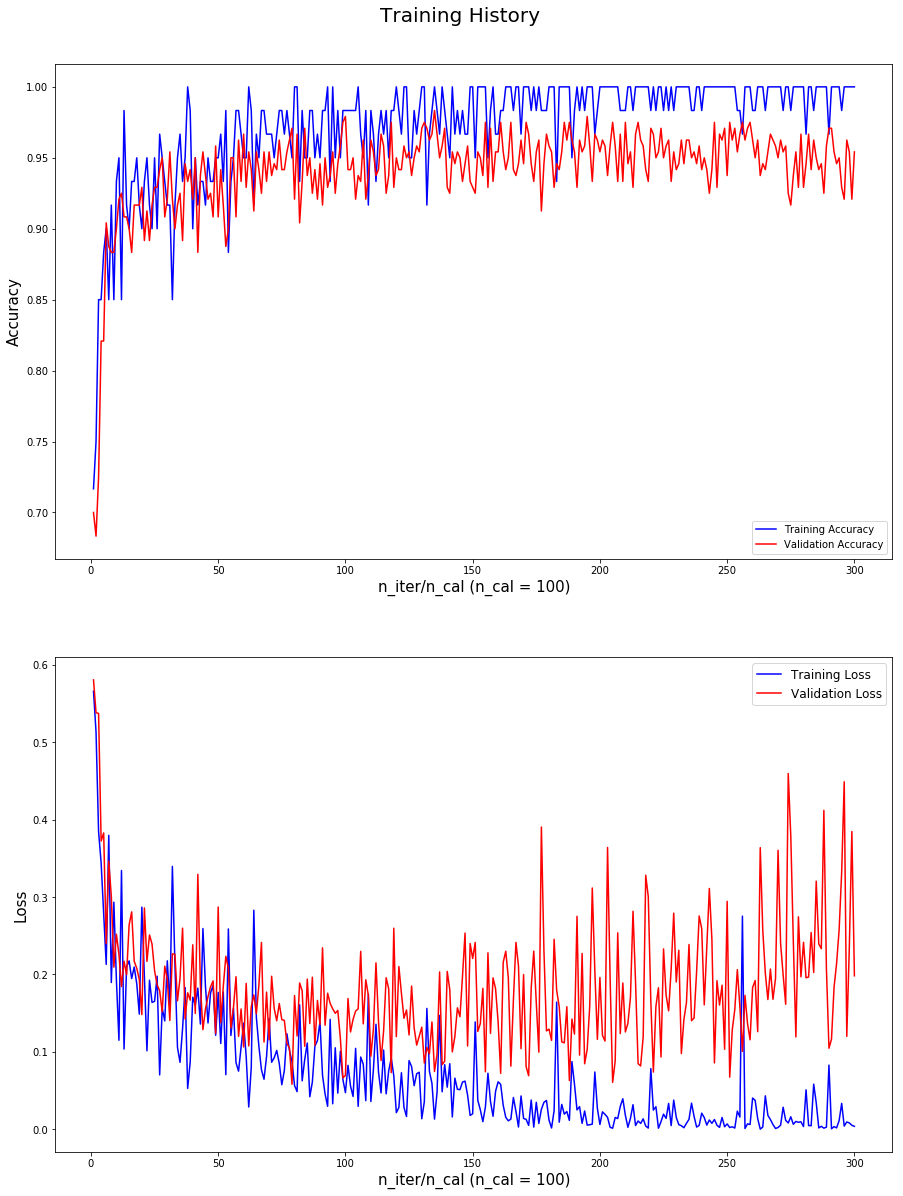

In [14]:
hist.table()

start_time = time.time()

while True:
    
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    ero_train_x, ero_train_y  = load_random_minibatch(ero_train_path, cls = 1, batch_size = int(t_batch/3))
    ulcer_train_x, ulcer_train_y = load_random_minibatch(ulcer_train_path, cls = 1, batch_size = int(t_batch/3))
    str_train_x, str_train_y = load_random_minibatch(str_train_path, cls = 1, batch_size = int(t_batch/3))
    train_x = np.vstack([neg_train_x, ero_train_x, ulcer_train_x, str_train_x])
    train_y = np.vstack([neg_train_y, ero_train_y, ulcer_train_y, str_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: lr})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        ero_valid_x, ero_valid_y  = load_random_minibatch(ero_valid_path, cls = 1, batch_size = int(v_batch/3))
        ulcer_valid_x, ulcer_valid_y = load_random_minibatch(ulcer_valid_path, cls = 1, batch_size = int(v_batch/3))
        str_valid_x, str_valid_y = load_random_minibatch(str_valid_path, cls = 1, batch_size = int(v_batch/3))
        valid_x = np.vstack([neg_valid_x, ero_valid_x, ulcer_valid_x, str_valid_x])
        valid_y = np.vstack([neg_valid_y, ero_valid_y, ulcer_valid_y, str_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'ND_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 30000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    lr *= 0.99999
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
np.arange(len(accr_valid))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [22]:
train_rf = RandomForestRegressor()
valid_rf = RandomForestRegressor()
train_rf.fit(np.arange(len(accr_train)).reshape(-1,1), accr_train)
valid_rf.fit(np.arange(len(accr_valid)).reshape(-1,1), accr_valid)

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [28]:
xp = np.arange(0, len(accr_train), 0.01).reshape(-1, 1)

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(accr_train, 'bo')
plt.plot(accr_valid, 'ro')
plt.plot(xp, train_rf.predict(xp), 'b--')
plt.plot(xp, valid_rf.predict(xp), 'r--')
plt.show()

In [34]:
from sklearn.svm import SVR

In [35]:
SVR(kernel = 'poly', degree = 3)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
1+1

In [ ]:
train_poly = SVR(kernel = 'poly', degree = 3)
valid_poly = SVR(kernel = 'poly', degree = 3)
train_poly.fit(np.arange(len(accr_train)).reshape(-1,1), accr_train)
valid_poly.fit(np.arange(len(accr_valid)).reshape(-1,1), accr_valid)

# 존나 오래 걸리네 

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
train_poly = SVR(kernel = 'poly', degree = 3, gamma='auto', max_iter = 10, verbose = True)
valid_poly = SVR(kernel = 'poly', degree = 3, gamma='auto', max_iter = 10, verbose = True)
train_poly.fit(np.arange(len(accr_train)).reshape(-1,1), accr_train)
valid_poly.fit(np.arange(len(accr_valid)).reshape(-1,1), accr_valid)

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(accr_train, 'b-')
plt.plot(accr_valid, 'r-')
plt.plot(xp, train_rf.predict(xp), 'b--')
plt.plot(xp, valid_rf.predict(xp), 'r--')
plt.show()

Training Time : 113 Min.
Early Stopping : False
Iteration : 24974



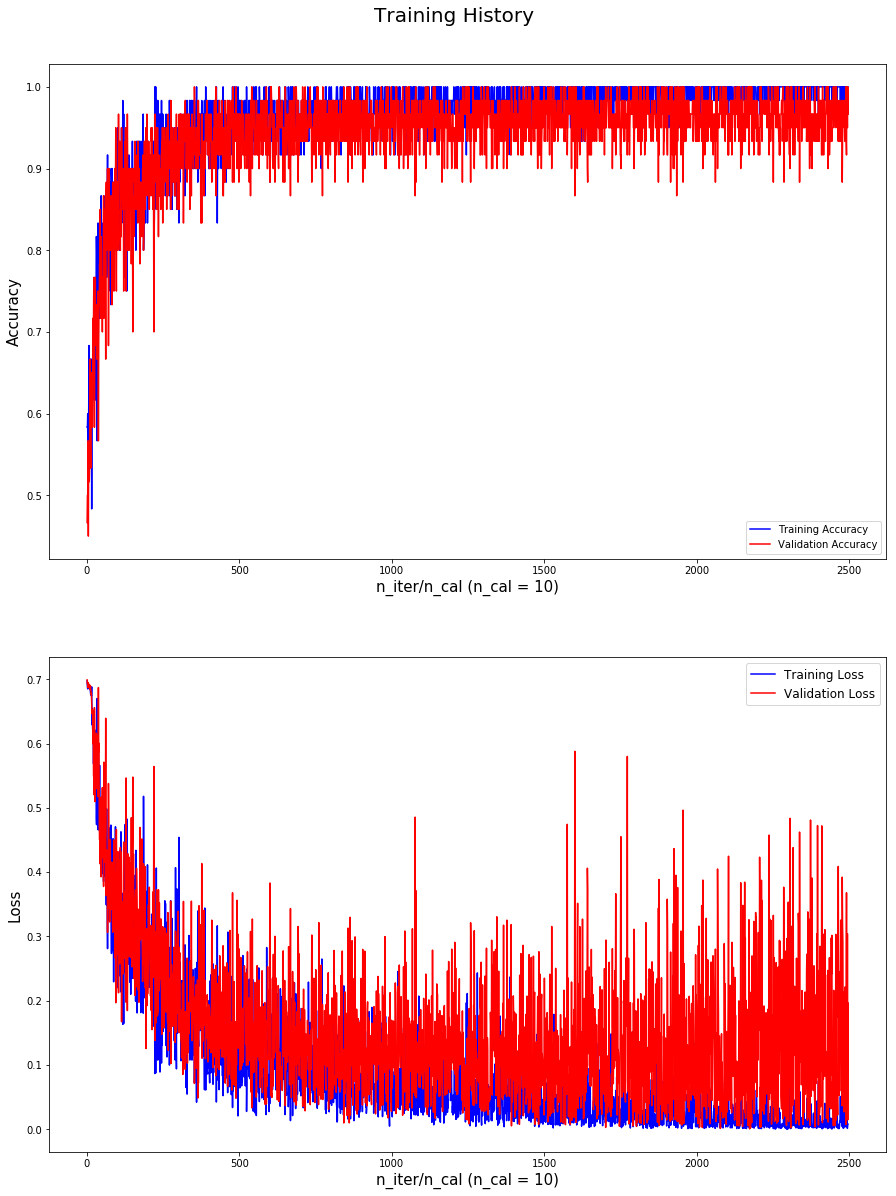

In [9]:
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval) 